# Data rate prediction notebook
The question we're trying to answer: how well can an AP predict the data rate a client will experience when it connects to it, using historical data?

## About the data set

Contains a time-indexed summary of the WiFi experiments performed at FEUP during January 2019.

In these experiments there were 4 stationary APs sending data through UDP to 4 mobile clients.
All APs used 802.11n, but each used its own independent channel.

Clients performed "laps" back and forth around the APs.

AP info:

* ap1, located at (41.178518,-8.595366), running on channel 6 (20 MHz centered at 2437 MHz)
* ap2, located at (41.178518,-8.595366), running on channel 38 (40 MHz centered at 5190 MHz)
* ap3, located at (41.178563,-8.596012), running on channel 11 (20 MHz centered at 2462 MHz)
* ap4, located at (41.178563,-8.596012), running on channel 46 (40 MHz centered at 5230 MHz)


### Column explanation:

* senderId: id of the node sending data (one of {ap1, ap2, ap3, ap4}).

* receiverId: id of the client node receiving data (one of {m1, w1, w2, w3}).

* systime: system time (1 Hz resolution) that this row refers to. All node clocks were synchronized through NTP.

* receiverDist: straight-line distance between sender and receiver, in meters, for the 1-second period systime period the row refers to. If we don't have data for a particular systime, linear interpolation between the two closest data points is used.

* receiverX: x coordinate of the receiver's position when space is discretized as a Cartesian plane and the sender is set to be the origin of the coordinate system. The x axis corresponds to east-west (positive values are east, negative values are west). Unit is meters. If we don't have data for a particular systime, linear interpolation between the two closest data points is used.

* receiverY: y coordinate of the receiver's position when space is discretized as a Cartesian plane and the sender is set to be the origin of the coordinate system. The y axis corresponds to north-south (positive values are north, negative values are south). Unit is meters. If we don't have data for a particular systime, linear interpolation between the two closest data points is used.

* receiverAlt: receiver's altitude, in meters.

* receiverSpeed: receiver's speed, in m/s.

* channelFreq: center frequency of the WiFi channel used, in MHz.

* channelBw: bandwidth of the WiFi channel used, in MHz.

* channelUtil: percentage of time the wireless medium was sensed to be busy during the 1-second period systime period the row refers to. If we don't have data for a particular systime, linear interpolation between the two closest data points is used.

* isInLap: 1 if this row's systime has been marked as being part of a time period where clients were doing laps around the APs, 0 otherwise.

* isIperfOn: 1 if row's systime corresponds to a period where iperf is known to have been running on the receiver side.

* rssiMean: the mean of the RSSI (Received Signal Strength Indicator) values of frames received by the client from the sender during the 1-second period systime period the row refers to. If no frames with RSSI information were received, this field is set to -100. Unit is dBm. 

* dataRateMean: the mean of the RSSI (Received Signal Strength Indicator) values of frames received by the client from the sender during the 1-second period systime period the row refers to. If no frames with RSSI information were received, this field is set to 0. Unit is Mbit/s. 

* nBytesReceived: total number of bytes received by the client from the sender during the 1-second period systime period the row refers to.


## Read data set
To note:
* We keep only data for colocated APs, either the (ap1, ap2) pair, or the (ap3, ap4) pair. This emulates a scenario where one AP supports multiple technologies.
* The throw away rows marked as having iperf turned off.

In [128]:
import pandas

IN_FNAME = "../data/feup-exp-201901/summary/final-exp-log.csv"

# load dataset
# line format: senderId,receiverId,systime,receiverX,receiverY,receiverAlt,
#              receiverSpeed,channelFreq,channelBw,chanUtil,isInLap,isIperfOn,
#              isDataResheived,rssiMean,dataRateMean,nBytesReceived -0976543

dataset = pandas.read_csv(IN_FNAME)
dataset = dataset.loc[dataset['isIperfOn'] == 1] # filter out periods when iperf was off
dataset = dataset.loc[dataset['senderId'].isin(('ap1','ap2'))] # filter out non-colocated APs
dataset = dataset.reset_index(drop=True)

## Let's eature correlation analysis

In [129]:
# let us print out a correlation matrix (weirdly, can't farm this out to a method
# because then it won't show in the notebook)

# prepare a data set for correlation analysis
corDs = dataset.copy()

# drop unneeded columns
corDs.drop(['systime', 'isInLap', 'senderId', 'receiverId', 'isIperfOn'], axis=1, inplace=True)

#corDs # uncomment if you want to print it out

In [130]:
# show correlation matrix for pearson (measures linear relationship between normally-distributed variables)
corMat = corDs.corr(method='pearson') 
corMat.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,receiverDist,receiverX,receiverY,receiverAlt,receiverSpeed,channelFreq,channelBw,channelUtil,rssiMean,dataRateMean,nBytesReceived
receiverDist,1,0.2,0.35,-0.35,0.43,-0.0028,-0.0028,-0.031,-0.63,-0.53,-0.52
receiverX,0.2,1,-0.63,0.23,-0.11,-0.014,-0.014,-0.1,-0.06,0.038,0.071
receiverY,0.35,-0.63,1,-0.51,0.34,0.018,0.018,0.11,-0.35,-0.33,-0.38
receiverAlt,-0.35,0.23,-0.51,1,-0.74,-0.055,-0.055,-0.12,0.34,0.35,0.49
receiverSpeed,0.43,-0.11,0.34,-0.74,1,0.063,0.063,0.12,-0.37,-0.45,-0.53
channelFreq,-0.0028,-0.014,0.018,-0.055,0.063,1,1,-0.14,0.014,0.42,0.37
channelBw,-0.0028,-0.014,0.018,-0.055,0.063,1,1,-0.14,0.014,0.42,0.37
channelUtil,-0.031,-0.1,0.11,-0.12,0.12,-0.14,-0.14,1,0.37,-0.28,-0.15
rssiMean,-0.63,-0.06,-0.35,0.34,-0.37,0.014,0.014,0.37,1,0.55,0.58
dataRateMean,-0.53,0.038,-0.33,0.35,-0.45,0.42,0.42,-0.28,0.55,1,0.86


In [131]:
corMat = corDs.corr(method='kendall') # non-parametric, rank based (sees how increasing rank of one variable changes rank of another)
                                      # spearman is alternative, gives higher values but is more error prone
corMat.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,receiverDist,receiverX,receiverY,receiverAlt,receiverSpeed,channelFreq,channelBw,channelUtil,rssiMean,dataRateMean,nBytesReceived
receiverDist,1,0.31,0.16,-0.17,0.19,0.001,0.001,-0.026,-0.52,-0.36,-0.33
receiverX,0.31,1,-0.35,0.16,-0.044,-0.011,-0.011,-0.059,-0.073,-0.0039,0.014
receiverY,0.16,-0.35,1,-0.51,0.3,0.036,0.036,0.05,-0.24,-0.22,-0.25
receiverAlt,-0.17,0.16,-0.51,1,-0.38,-0.039,-0.039,-0.069,0.24,0.21,0.25
receiverSpeed,0.19,-0.044,0.3,-0.38,1,0.052,0.052,0.067,-0.24,-0.23,-0.24
channelFreq,0.001,-0.011,0.036,-0.039,0.052,1,1,-0.047,-0.13,0.3,0.3
channelBw,0.001,-0.011,0.036,-0.039,0.052,1,1,-0.047,-0.13,0.3,0.3
channelUtil,-0.026,-0.059,0.05,-0.069,0.067,-0.047,-0.047,1,0.16,-0.13,-0.029
rssiMean,-0.52,-0.073,-0.24,0.24,-0.24,-0.13,-0.13,0.16,1,0.47,0.49
dataRateMean,-0.36,-0.0039,-0.22,0.21,-0.23,0.3,0.3,-0.13,0.47,1,0.78


In [132]:
corMat = corDs.corr(method='spearman') # non-parametric, rank based (sees how increasing rank of one variable changes rank of another)
                                      # compared to kendall, gives higher values but is more error prone
corMat.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,receiverDist,receiverX,receiverY,receiverAlt,receiverSpeed,channelFreq,channelBw,channelUtil,rssiMean,dataRateMean,nBytesReceived
receiverDist,1,0.3,0.22,-0.22,0.28,0.0013,0.0013,-0.05,-0.71,-0.52,-0.49
receiverX,0.3,1,-0.52,0.31,-0.08,-0.013,-0.013,-0.096,-0.11,-0.01,0.0049
receiverY,0.22,-0.52,1,-0.68,0.44,0.044,0.044,0.078,-0.34,-0.31,-0.36
receiverAlt,-0.22,0.31,-0.68,1,-0.55,-0.047,-0.047,-0.099,0.35,0.32,0.37
receiverSpeed,0.28,-0.08,0.44,-0.55,1,0.061,0.061,0.089,-0.39,-0.35,-0.37
channelFreq,0.0013,-0.013,0.044,-0.047,0.061,1,1,-0.057,-0.15,0.37,0.36
channelBw,0.0013,-0.013,0.044,-0.047,0.061,1,1,-0.057,-0.15,0.37,0.36
channelUtil,-0.05,-0.096,0.078,-0.099,0.089,-0.057,-0.057,1,0.24,-0.17,-0.056
rssiMean,-0.71,-0.11,-0.34,0.35,-0.39,-0.15,-0.15,0.24,1,0.64,0.67
dataRateMean,-0.52,-0.01,-0.31,0.32,-0.35,0.37,0.37,-0.17,0.64,1,0.93


In [133]:
del corDs, corMat # get rid of stuff we don't need anymore

### Results discussion
* RSSI is reasonably correlated with throughput.
* Distance is reasonably negatively-correlated with throughput, as expected.
* RSSI and distance correlate pretty well with one another.
* Channel utilization is not useful in this data set because there is only one client per channel.
* Data rate is pretty much a dead ringer for throughput. I'm thinking we should actually focus on predicting data rate rather than throughput. Data rate should be easier to predict as it's independent from the amount of data the client has to send.

## Let's try it as a classification problem (predict data rate as discrete variable)
We start by defining some classifiers.
We discretize data rate as a 4-class variable, with each class representing a different quartile.

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def printSeparator():
  print('----------------------------------------------------------------\n')

def runClassifier(clf, clfName, xTrain, yTrain, xTest, yTest):
  """
    Run single classifier, passed in as argument clf.
  """

  clf.fit(xTrain, yTrain)
  yPred = clf.predict(xTest) # predict on the unseen data
  print("Accuracy of", clfName, ":", accuracy_score(yPred, yTest))
  print(classification_report(yPred, yTest))    
  printSeparator()

def runClassifiers(df, targetName, scaler=None, nquantiles=4):
  """
    Run multiple classifiers for the data frame passed in as argument df.
  """

  # discretize target

  # start by printing some information about the bins
  uniBins = pandas.qcut(df[targetName], q=nquantiles).unique()
  uniBins = uniBins.ravel()
  uniBins.sort()
  print("Discretizing", targetName, "into", nquantiles, "quantiles, yielding bins:\n", uniBins)

  df[targetName] = pandas.qcut(df[targetName], q=nquantiles, labels=False) # actually discretize stuff

  #  split dataset into training and test
  x = df.drop(targetName, axis=1) # x contains all the features
  y = df[targetName] # y contains only the label

  # scaling, see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  if scaler:
    x = scaler.fit_transform(x)

  # xTrain contains features for training, xTest contains features for testing
  # test_size = 0.3 means 30% data for testing
  # random_state = 1, is the seed value used by the random number generator
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=1)

  yCounts = []
  for idx, count in yTest.value_counts().iteritems():
    yCounts.append((idx, count))
  yCounts.sort()
  print("Number of entries in each bin for test y's truth:", yCounts)
  printSeparator()
    
  # train and test models

  # logistic regression
  clfLogr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, random_state=1)
  runClassifier(clfLogr, "logistic regression", xTrain, yTrain, xTest, yTest)
    
  # svm
  clfSvm = svm.SVC(gamma='scale', random_state=1)
  runClassifier(clfSvm, "support vecto machine", xTrain, yTrain, xTest, yTest)
    
  # knn
  clfKnn = KNeighborsClassifier()
  runClassifier(clfKnn, "k-Nearest Neighbors", xTrain, yTrain, xTest, yTest)

  # decision tree    
  clfDt = DecisionTreeClassifier(random_state=1)
  runClassifier(clfDt, "decision tree", xTrain, yTrain, xTest, yTest)

  # random forest
  clfRf = RandomForestClassifier(n_estimators=100, random_state=1)
  runClassifier(clfRf, "random forest", xTrain, yTrain, xTest, yTest)
    
  # neural network (Multi Layer Perceptron w/ backpropagation)
  clfMlp = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
  runClassifier(clfMlp, "neural network - Multi-Layer Perceptron (MLP)", xTrain, yTrain, xTest, yTest)

### Let's run the classifiers on the original features

#### Notes regarding classification report:
* **precision**: TP / (TP + FP), or what percentage of predicted positives are true positives.
* **recall**: TP / (TP+FN), or what percentage of actual positives were predicted to be positive.
* **f1-score**: can be interpreted as a weighted harmonic mean of precision and recall, (best score is 1, worst is 0).
* **support**: number of entries the classifier classified as belonging to the class.


In [135]:
clDf = dataset.copy() # work on copy to preserve original

# we don't care for some columns no more
clDf.drop(['senderId', 'receiverId', 'channelUtil', 'nBytesReceived'], axis=1, inplace=True)

# test drops, drop different columns to see how they affect the results
#clDf.drop(['receiverAlt', 'receiverDist'], axis=1, inplace=True)
#clDf.drop(['receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY', \
#    'channelFreq', 'channelBw'], axis=1, inplace=True) # drop everything but rssiMean

#  split dataset into training and test
x = clDf.drop("dataRateMean", axis=1) # x contains all the features
y = clDf["dataRateMean"] # y contains only the label

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler() # subtract minimum and divide by range
runClassifiers(df=clDf, targetName="dataRateMean", scaler=mms, nquantiles=4)

del clDf, x, y, mms # don't need them anymore

Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(-0.001, 8.625, closed='right')
 Interval(8.625, 62.89, closed='right')
 Interval(62.89, 104.029, closed='right')
 Interval(104.029, 292.69, closed='right')]
Number of entries in each bin for test y's truth: [(0, 402), (1, 408), (2, 435), (3, 420)]
----------------------------------------------------------------

Accuracy of logistic regression : 0.7987987987987988
              precision    recall  f1-score   support

           0       0.88      0.79      0.84       447
           1       0.67      0.72      0.69       384
           2       0.76      0.87      0.81       379
           3       0.88      0.82      0.85       455

    accuracy                           0.80      1665
   macro avg       0.80      0.80      0.80      1665
weighted avg       0.81      0.80      0.80      1665

----------------------------------------------------------------

Accuracy of support vecto machine : 0.8474474474474475
       

### Discussion
* Accuracy is "not great, not terrible".
* Random forest yielded the best accuracy, winning by a small margin over neural network and kNN.

### Let's now use PCA to reduce dimensionality before using the classifiers

In [136]:
def getPcaDf(df, targetVar=0.95):
  # separate features from target
  features = ['receiverX', 'receiverY', 'receiverDist', 'receiverSpeed', 'receiverAlt', \
              'channelFreq', 'channelBw', 'rssiMean']
  x = df.loc[:, features].values # x represents our features

  # standardization, see the following articles: 
  # 1. https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  # 2. https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2
  from sklearn.preprocessing import StandardScaler
  x = StandardScaler().fit_transform(x) # subtract mean and then scale to unit variance

  # run PCA
  from sklearn import decomposition
  pca = decomposition.PCA(targetVar) # maintain a targetVar portion of the variance
  pca.fit(x) 

  print("Found", pca.n_components_, "PCA components:", pca.explained_variance_)
  print("Explained variance ratios:", pca.explained_variance_ratio_, "total:", \
        sum(pca.explained_variance_ratio_))

  prinComps = pca.transform(x) # apply dimensionality reduction to x

  # create a data frame out of x
  pcaDf = pandas.DataFrame(data = prinComps)
  pcaDf['dataRateMean'] =  df['dataRateMean']

  return pcaDf

pcaDf = getPcaDf(dataset)
runClassifiers(df=pcaDf, targetName="dataRateMean", scaler=None, nquantiles=4)

Found 6 PCA components: [2.83777646 2.00023362 1.50756115 0.84120669 0.38076478 0.27464296]
Explained variance ratios: [0.35465812 0.24998414 0.18841118 0.10513188 0.04758702 0.03432418] total: 0.9800965172976589
Discretizing dataRateMean into 4 quantiles, yielding bins:
 [Interval(-0.001, 8.625, closed='right')
 Interval(8.625, 62.89, closed='right')
 Interval(62.89, 104.029, closed='right')
 Interval(104.029, 292.69, closed='right')]
Number of entries in each bin for test y's truth: [(0, 402), (1, 408), (2, 435), (3, 420)]
----------------------------------------------------------------

Accuracy of logistic regression : 0.8126126126126126
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       446
           1       0.67      0.74      0.70       373
           2       0.82      0.88      0.85       405
           3       0.90      0.85      0.87       441

    accuracy                           0.81      1665
   macro avg       0.81 

### Discussion
* PCA didn't actually improve accuracy. Why?
* kNN was the most accurate, by a small margin over random forest and neural network.

## Let's do regression now (predict data rate as a continuous variable)
We begin by defining some regression models.

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

def rmse(yTrue, yPred):
  """
    Compute root mean square error.
  """
  return numpy.sqrt(numpy.mean(numpy.square(yTrue - yPred)))

def runRegression(reg, regName, xTrain, yTrain, xTest, yTest, printSep=True):
  """
    Run single regression, passed in as argument reg.
  """

  print(regName)
  reg.fit(xTrain, yTrain)
  yPred = reg.predict(xTest) # predict on the unseen data
  yPred = yPred.clip(min=0) # because we know data rate can't be negative, make negative values zero
  print("Root-Mean-Square Error: %.2f" % rmse(yTest, yPred))
  print('Variance score: %.2f' % r2_score(yTest, yPred)) # 1 is perfect prediction
  if printSep: printSeparator()
    
  return yPred

def runRegressions(df, targetName, scaler=None):
  """
    Run multiple regressions for the data frame passed in as argument df.
  """

  #  split dataset into training and test
  x = df.drop(targetName, axis=1) # x contains all the features
  y = df[targetName] # y contains only the label

  # scaling, see: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
  if scaler:
    x = scaler.fit_transform(x)

  # xTrain contains features for training, xTest contains features for testing
  # test_size = 0.3 means 30% data for testing
  # random_state = 1, is the seed value used by the random number generator
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 1)    
    
  # some info about the data
  print("Train y data information - min:", numpy.min(yTrain), ", max:", numpy.max(yTrain), ', mean:', \
        numpy.mean(yTrain), ", standard deviation:", numpy.std(yTrain))
  print("Test y data information - min:", numpy.min(yTest), ", max:", numpy.max(yTest), ', mean:', \
        numpy.mean(yTest), ", standard deviation:", numpy.std(yTest))
  printSeparator()
    
  # train and test models

  # linear regression
  regLinr = LinearRegression()
  yPredLinr = runRegression(regLinr, "Linear regression", xTrain, yTrain, xTest, yTest, printSep=False)
#  print('Linear regression coefs: \n', regLinr.coef_)  
  printSeparator()

  # svr
  regSvr = svm.SVR(gamma='scale')
  yPredSvr = runRegression(regSvr, "Support Vector Regression (SVR)", xTrain, yTrain, xTest, yTest)

  # neural network (Multi Layer Perceptron w/ backpropagation)
  regMlp = MLPRegressor(solver='lbfgs', random_state=1, max_iter=1000)
  yPredMlp = runRegression(regMlp, "Neural network - Multi-Layer Perceptron (MLP)", xTrain, yTrain, xTest, yTest)
    
  y = numpy.array([yTrain, yTest, yPredLinr, yPredSvr, yPredMlp]) 

  # plot violins for the different y distributions
  vioInPairs = (('Train', yTrain.values), ('Test', yTest.values), ('Linear regression', yPredLinr), \
                ('Support vector regression', yPredSvr), ('Multi-layer perceptron', yPredMlp))
  vioDf = pandas.DataFrame(columns=['Dataset','Mean data rate (Mbit/s)'])
  crow = 0
  for x, yarray in vioInPairs:
    for y in yarray:
      vioDf.loc[crow] = [x, y]
      crow += 1
  plt.figure(figsize=(14,8)) # new figure
  sns.set(style="whitegrid")
  sns.violinplot(x='Dataset', y='Mean data rate (Mbit/s)', data=vioDf)
  plt.figure() # starts a new figure

### Try regression on original features

Train y data information - min: 0.0 , max: 281.306773 , mean: 65.80067886144734 , standard deviation: 56.16036507546545
Test y data information - min: 0.0 , max: 292.6900100000001 , mean: 67.34738453333334 , standard deviation: 56.72589475772961
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 35.88
Variance score: 0.60
----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 30.71
Variance score: 0.71
----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 19.34
Variance score: 0.88
----------------------------------------------------------------



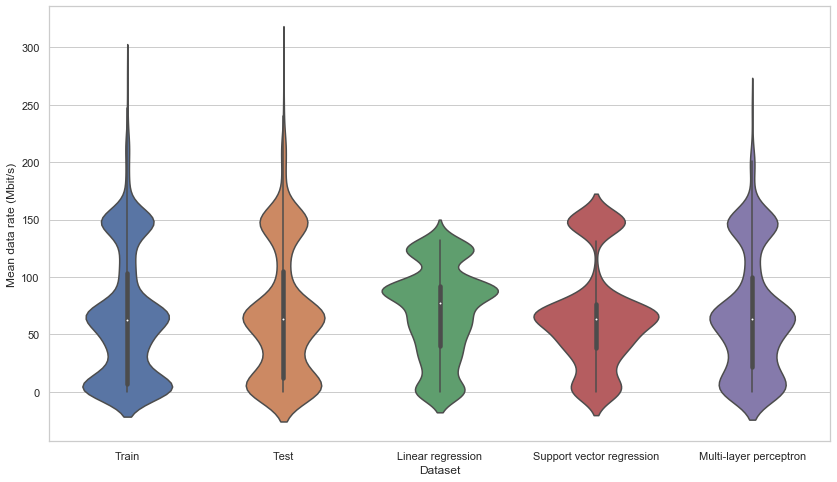

<Figure size 432x288 with 0 Axes>

In [138]:
regDf = dataset.copy() # work on copy to preserve original

# we don't care for some columns no more
regDf.drop(['senderId', 'receiverId', 'channelUtil', 'nBytesReceived'], axis=1, inplace=True)

# test drops, drop different columns to see how they affect the results
#regDf.drop(['receiverAlt', 'receiverDist'], axis=1, inplace=True)
#regDf.drop(['receiverAlt', 'receiverDist', 'receiverSpeed', 'receiverX', 'receiverY', \
#    'channelFreq', 'channelBw'], axis=1, inplace=True) # drop everything but rssiMean

#  split dataset into training and test
x = regDf.drop("dataRateMean", axis=1) # x contains all the features
y = regDf["dataRateMean"] # y contains only the label

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler() # subtract minimum and divide by range
runRegressions(df=regDf, targetName="dataRateMean", scaler=mms)

del regDf, x, y, mms # don't need it any more

### Discussion
* Performance was again "not great, not terrible".
* Neural network significantly outperformed the other methods in terms of RMSE.
* Neural network was significantly slower than other methods.

## Try regression on principal components
I.e. perform PCA first.

Found 7 PCA components: [2.83777646 2.00023362 1.50756115 0.84120669 0.38076478 0.27464296
 0.15925657]
Explained variance ratios: [0.35465812 0.24998414 0.18841118 0.10513188 0.04758702 0.03432418
 0.01990348] total: 1.0
Train y data information - min: 0.0 , max: 281.306773 , mean: 65.80067886144734 , standard deviation: 56.16036507546545
Test y data information - min: 0.0 , max: 292.6900100000001 , mean: 67.34738453333334 , standard deviation: 56.72589475772961
----------------------------------------------------------------

Linear regression
Root-Mean-Square Error: 35.90
Variance score: 0.60
----------------------------------------------------------------

Support Vector Regression (SVR)
Root-Mean-Square Error: 28.95
Variance score: 0.74
----------------------------------------------------------------

Neural network - Multi-Layer Perceptron (MLP)
Root-Mean-Square Error: 18.19
Variance score: 0.90
----------------------------------------------------------------



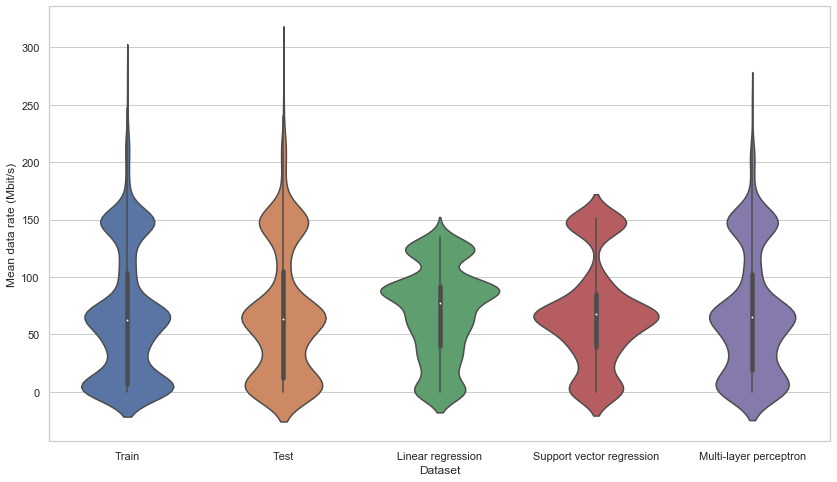

<Figure size 432x288 with 0 Axes>

In [139]:
pcaDf = getPcaDf(dataset, targetVar=0.99) # 99% variance works slightly better than 95% in this instance
runRegressions(df=pcaDf, targetName="dataRateMean", scaler=None)

### Discussion
* Unlike in classification, PCA helped regression performance slightly for SVR and MLP. Linear regression is pretty much untouched.
* Neural network still significantly outperformed the other methods.

## Conclusions and future work
* Discretization does not seem to improve predictability all that much.
* Using a neural network performs best for regression and well for classification too, but takes the largest amount of time.
* Random forest (original features) and kNN (principal components) perform best for classification, but by a small margin over a neural network.
* In the future we'll want to have experiments that give us data about the impact of channel utilization on throughput. Throughput should be a function of data rate and channel utilization.